In [1]:
import sys, os, time, shutil, random
from pathlib import Path
# _cwd = os.getcwd()
# os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
from omnibelt import unspecified_argument
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
# import timm
torch.set_printoptions(linewidth=300, sci_mode=False)
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

# fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets


# from src import sample_full_interventions, response_mat, factor_reponses
# from src.responses import sample_full_interventions

# fig.initialize('sae')
# from omnifig.projects import sae
# import networkx as nx

# # from src import sample_full_interventions, response_mat, factor_reponses
# dataset = None
# src = None

import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP
distinct_colors = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",]
rank = 0
world_size = 1
init_method="file:///C:/Users/anwan/Documents/tmp/env"
# dist.init_process_group(
#    "gloo",
#    rank=rank,
#    init_method=init_method,
#    world_size=world_size)

from model import AutoEncoder
import utils
import datasets

2022-05-08 12:04:45.614054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-05-08 12:04:45.614068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
imgroot = Path('figures')
imgroot.mkdir(exist_ok=True)

In [3]:
dname = 'celeba_64'
dname = 'mnist'
# dname = 'cifar10'

In [4]:
root = Path('checkpoints')
ds_ckpts = list(root.glob('*'))
ds_ckpts

[PosixPath('checkpoints/celeba_64'),
 PosixPath('checkpoints/cifar10'),
 PosixPath('checkpoints/mnist'),
 PosixPath('checkpoints/celeba_64-20220119T083217Z-001.zip'),
 PosixPath('checkpoints/cifar10-20220119T083215Z-002.zip'),
 PosixPath('checkpoints/mnist-20220119T083212Z-001.zip')]

In [5]:
path = random.choice(ds_ckpts)
# path = root / 'mnist'
path = root / dname
if dname == 'cifar10':
    path = path / 'qualitative'
path

PosixPath('checkpoints/mnist')

In [6]:
ckpt = torch.load(path/'checkpoint.pt', map_location='cpu')

# checkpoint = torch.load(eval_args.checkpoint, map_location='cpu')
args = ckpt['args']
if not hasattr(args, 'ada_groups'):
    args.ada_groups = False
if not hasattr(args, 'min_groups_per_scale'):
    args.min_groups_per_scale = 1
if not hasattr(args, 'num_mixture_dec'):
    args.num_mixture_dec = 10
# if eval_args.batch_size > 0:
#     args.batch_size = eval_args.batch_size
arch_instance = utils.get_arch_cells(args.arch_instance)

In [7]:
model = AutoEncoder(args, None, arch_instance)
model.load_state_dict(ckpt['state_dict'], strict=False);
model = model.cuda();

len log norm: 183
len bn: 128


In [8]:
model.eval();

In [9]:
# model.train();

In [10]:
def set_bn(model, bn_eval_mode, num_samples=1, t=1.0, iter=100):
    if bn_eval_mode:
        model.eval()
    else:
        model.train()
        with autocast():
            for i in range(iter):
                if i % 10 == 0:
                    print('setting BN statistics iter %d out of %d' % (i+1, iter))
                model.sample(num_samples, t)
        model.eval()

In [11]:
temperature = 0.7
bn_eval_mode = True

In [12]:
# os.environ['OMNILEARN_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data/'
os.environ['OMNILEARN_DATA_DIR']

'/is/ei/fleeb/workspace/local_data/'

In [13]:
# with torch.no_grad():
# #     set_bn(model, bn_eval_mode, num_samples=36, t=temperature, iter=500)
#     x = model.sample(24, temperature)
#     output = model.decoder_output(x)
#     output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
#                         else output.sample()
# # output_img.shape
# util.plot_imgs(output_img);

In [14]:
_global_eps_table = None
def encode(x, t=1., prior=False, distr=True, eps_table=unspecified_argument, **kwargs):
    if eps_table is unspecified_argument:
        eps_table = _global_eps_table
    with torch.no_grad():
        x = x.cuda()
        return model.encode(x, t=t, distr=distr, prior=prior,eps_table=eps_table,  **kwargs)

def decode(all_q, t=1., eps_table=unspecified_argument, **kwargs):
    if eps_table is unspecified_argument:
        eps_table = _global_eps_table
    with torch.no_grad():
#         all_q = [q.cuda() for q in all_q]
        out = model.decode(all_q, t=t,eps_table=eps_table,  **kwargs)
        return to_img(out).cpu()

def to_img(logits):
    with torch.no_grad():
        img = model.decoder_output(logits)
        img = img.mean if isinstance(img, torch.distributions.bernoulli.Bernoulli) \
                            else img.sample()
    return img.cpu()

def enc(x):
    zs, ps = encode(x, distr=False, prior=True)
    return [z.sub(p.mu).div(p.sigma) for z, p in zip(zs, ps)]
    # return [out[0].mu] + [o.eps for o in out[1:]]
def dec(q):
    return decode([None], eps_table=q)


In [15]:
if dname == 'mnist':
    bsnum = 24
    dataset = fig.quick_run('load-data', name='mnist', batch_size=bsnum, seed=11)
elif dname == 'cifar10':
    bsnum = 24
    dataset = fig.quick_run('load-data', name='cifar10', batch_size=bsnum, seed=11)
elif dname == 'celeba_64':
    bsnum = 12
    dataset = fig.quick_run('load-data', name='celeba', batch_size=bsnum, seed=11, size=64, **{'_dataset_mod': 'interpolated'})
else:
    assert False
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 24
|  > shuffle: True (by default)
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > wrappers: [] (by default)
|  > mode-wrappers: {} (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > default-mode --> mode: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'mnist'
|  > _dataset_mod: [] (by default)
|  > mode-aliases: {} (by default)
|  > seed: 11
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 11
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/mnist)
|  >  > dataroot: None (by default)
|  >  > mode: 'train'
|  >  > download: False (by default)
|  >  > train: True (by default)
|  >  > resiz

60000

In [16]:
batch = dataset.get_batch()
X, *other = batch
X.shape

torch.Size([24, 1, 32, 32])

In [500]:
print([tuple(z.shape[1:]) for z in zs])

[(20, 4, 4), (20, 4, 4), (20, 4, 4), (20, 4, 4), (20, 4, 4), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8), (20, 8, 8)]


In [501]:
torch.Generator().initial_seed()

67280421310721

In [17]:
# util.plot_imgs(X);

<IPython.core.display.Javascript object>


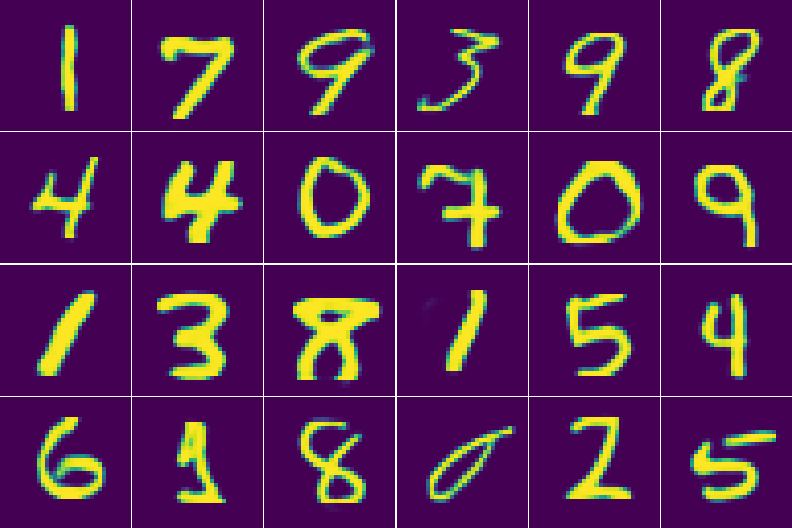

In [18]:
zs, ps = encode(X, distr=False, prior=True, eps_table=None)
_hidden_zs = [z[0] for z in zs]
def gen_eps_table(N, t=1., gen=None):
    if not isinstance(N, int):
        N = N.shape[0]
#     if expand:
#         return [torch.randn(1, *z.shape, generator=gen).mul(t).expand(N, *z.shape).to(z) for z in _hidden_zs]
    return [torch.randn(N,*z.shape, generator=gen).mul(t).to(z) for z in _hidden_zs]
rec = decode(zs)
util.plot_imgs(rec);

<IPython.core.display.Javascript object>


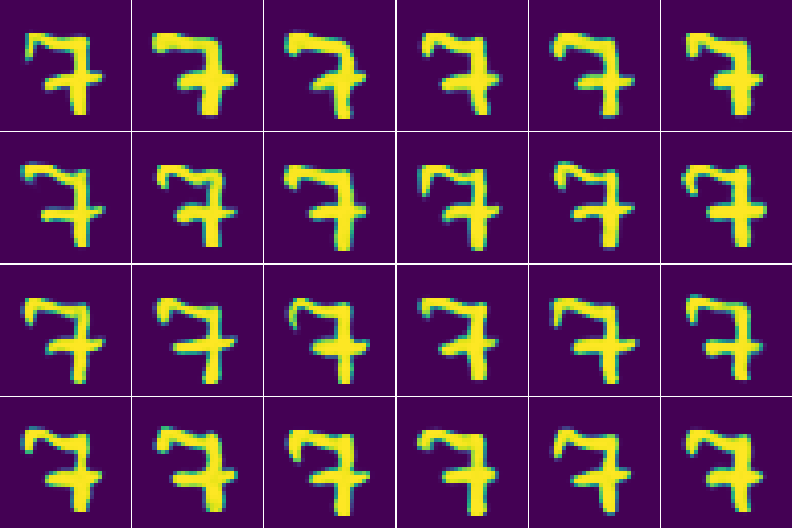

In [19]:
Xc = X[[torch.randint(len(X), size=()).item()]].expand(*X.shape)
util.plot_imgs(decode(encode(Xc, distr=True, eps_table=None), eps_table=None));

In [20]:
_global_eps_table = gen_eps_table(1, t=1, gen=torch.Generator().manual_seed(101))

In [21]:
# zis = zs.copy()
# zis = zis[:5]
# dis = decode(zis, t=0)
# util.plot_imgs(dis);

In [20]:
# util.plot_imgs(decode(encode(dis)));

In [21]:
# native reconstruction
# with torch.no_grad():
#     out = model(X)[0]
#     out = to_img(out)
# util.plot_imgs(out);

In [22]:
# native generate
# with torch.no_grad():
#     g = to_img(model.sample(12, t=.9))
#     g = g.cpu()
# util.plot_imgs(g);

In [72]:
# idx = np.random.randint(len(X))
x = X.clone()
# x = g.clone()
# x[:] = x[idx:idx+1]
# Zs, Ps = encode(x, t=0., prior=True)

In [27]:
# bnum = 8
# sel = np.arange(len(x))[-5:]
# bnum = len(sel)
# util.plot_imgs(util.combine_dims(seqs[:, sel].contiguous(), start=0, end=2), W=bnum);

In [28]:
# num = 5
# zs = [*Zs[:num], Ps[num].sample()[0]]
# util.plot_imgs(decode(zs,t=0.));

In [22]:
q = enc(X)
len(q)

15

In [23]:
r = dec(q)
r.shape

torch.Size([24, 1, 32, 32])

<IPython.core.display.Javascript object>


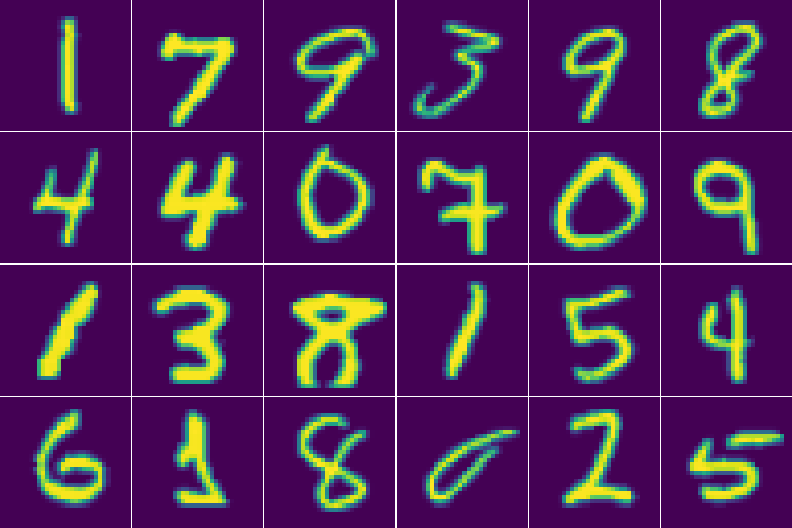

<IPython.core.display.Javascript object>


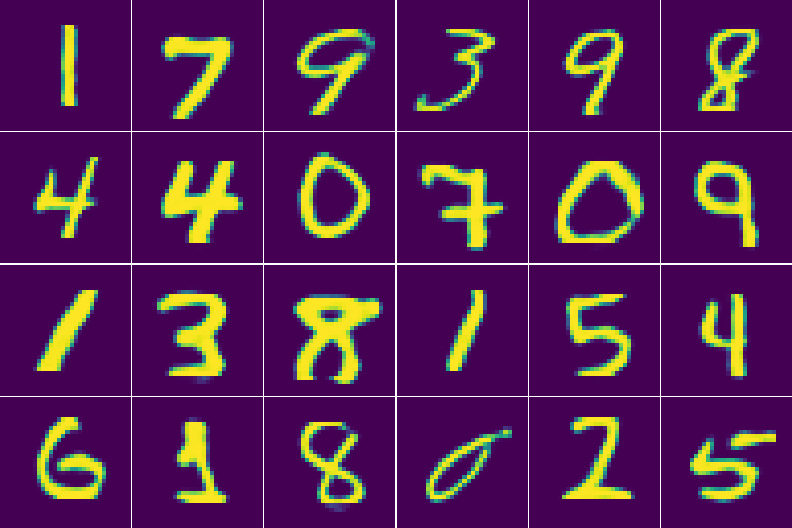

In [24]:
util.plot_imgs(X);
util.plot_imgs(r);

<IPython.core.display.Javascript object>


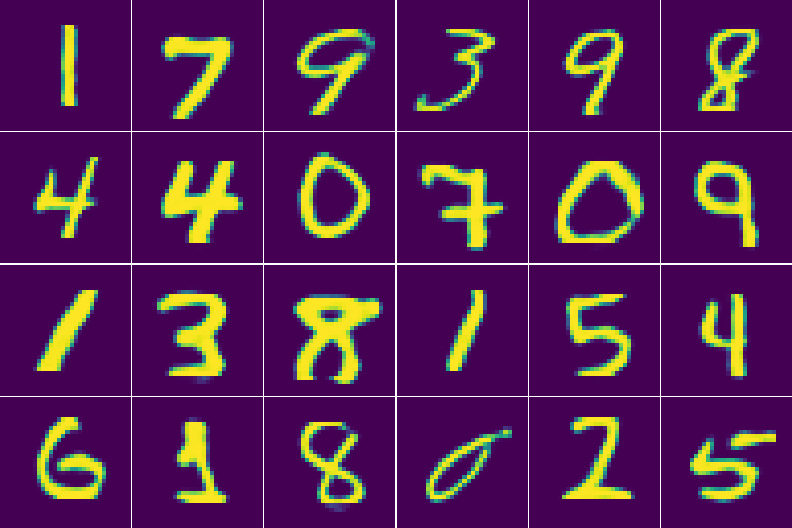

In [25]:
util.plot_imgs(dec(q));

<IPython.core.display.Javascript object>


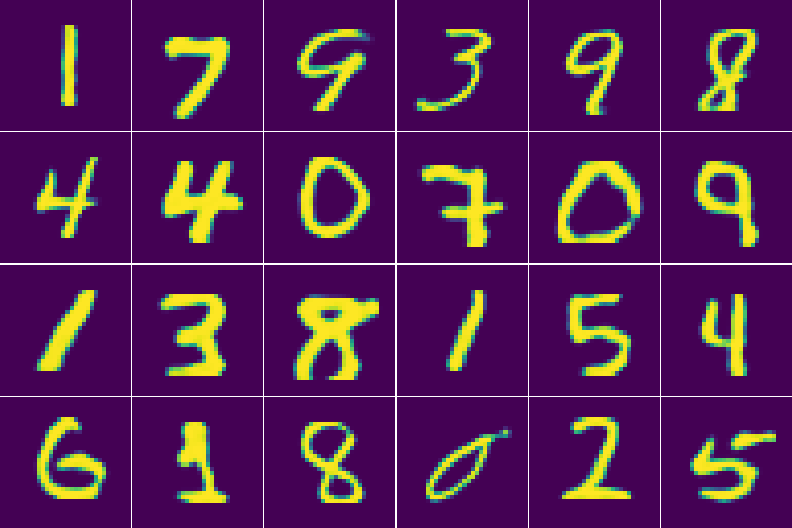

In [26]:
util.plot_imgs(dec(enc(r)));

<IPython.core.display.Javascript object>


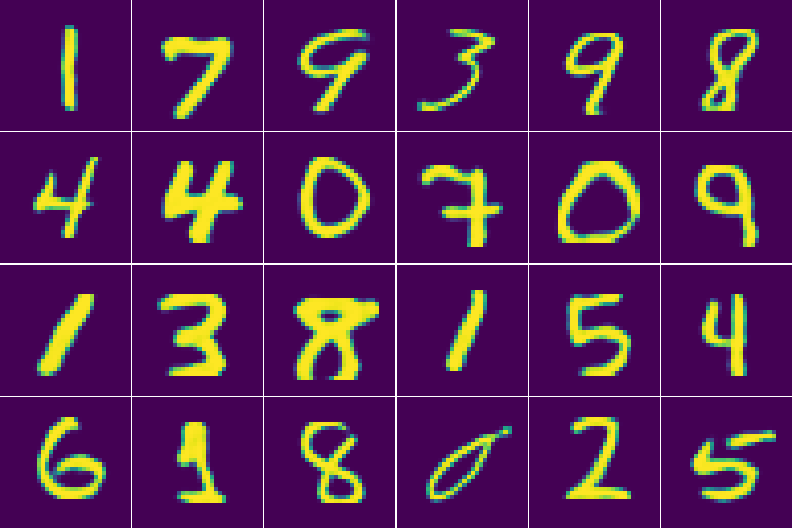

In [27]:

z2s = encode(rec)
rec2 = decode(z2s)
util.plot_imgs(rec2);

In [28]:
n_steps = 24
ends = gen_eps_table(2, t=1, gen=torch.Generator().manual_seed(101))
progress = torch.linspace(0,1.,n_steps).view(-1, 1,1,1).to(ends[0])
seq = [es[1:]*progress + es[:-1]*(1-progress) for es in ends]

<IPython.core.display.Javascript object>


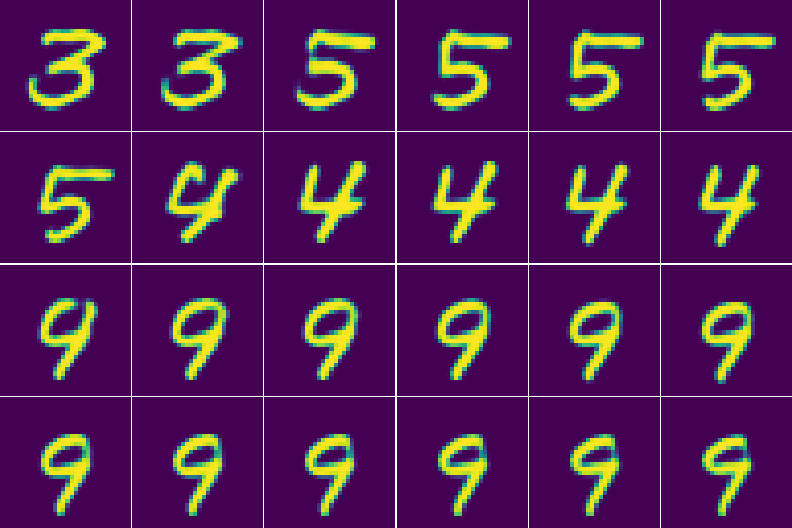

In [29]:
util.plot_imgs(dec(seq));

In [30]:
launch = X.clone()

/tmp/ipykernel_23216/639210667.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


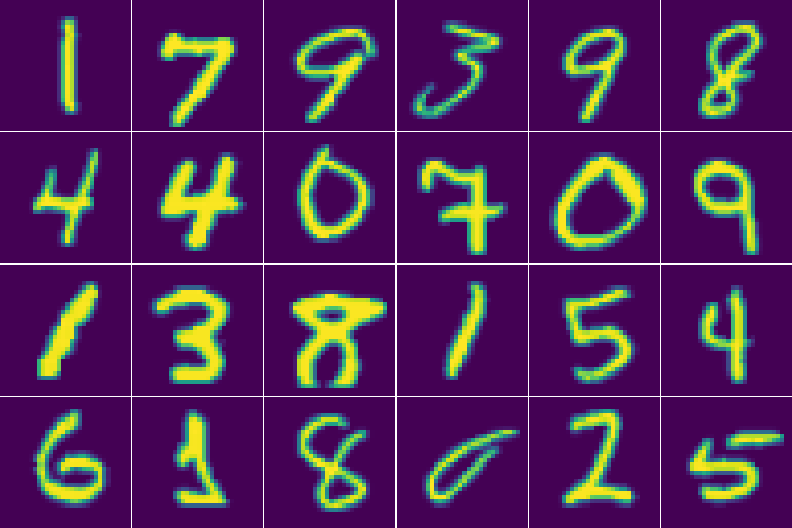

<IPython.core.display.Javascript object>


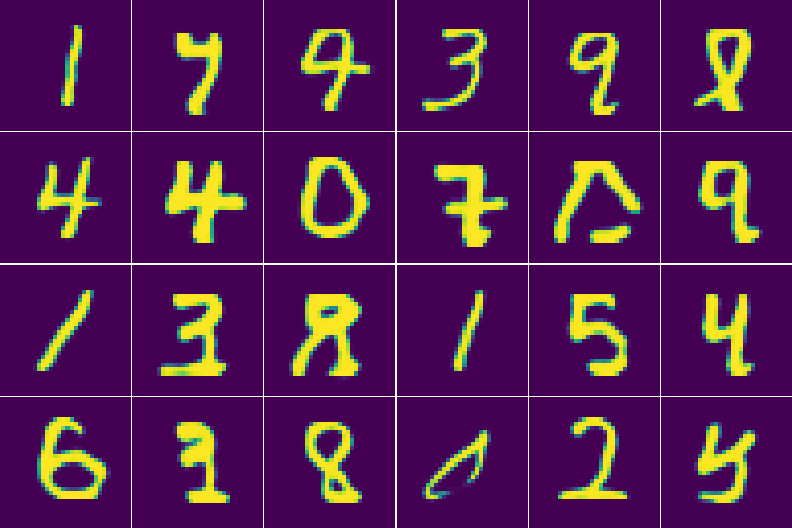

In [31]:
for _ in tqdm(range(10)):
    launch = dec(enc(launch))
util.plot_imgs(X);
util.plot_imgs(launch);

In [32]:
# Zc = enc(Xc)
# # z2s = encode(rec)
# # rec2 = decode(z2s)
# # util.plot_imgs(Xc);
# delta = [zc.add(torch.randn_like(zc).div(8)) for zc in Zc]
# util.plot_imgs(dec(delta));

In [62]:
N = 10
B = 20
K = len(Zc)
B, K

(20, 15)

In [61]:
zbase = gen_eps_table(N)
len(zbase)

15

In [54]:
zbase[0].shape

torch.Size([1, 20, 4, 4])

In [65]:
dZs, dZ2s = [], []
for i in tqdm(range(K)):
    zs = [z.unsqueeze(0).expand(B, *z.shape).contiguous().view(B*N, *z.shape[1:]) for j, z in enumerate(zbase)]
    izs = [(torch.randn_like(z) if i == j else z) for j, z in enumerate(zs)]
    
    z2s = enc(dec(zs))
    iz2s = enc(dec(izs))
    
    dzs = torch.stack([iz.sub(z).pow(2).view(B, N, -1).mean(-1) for iz, z in zip(izs, zs)], -1)
    dz2s = torch.stack([iz2.sub(z2).pow(2).view(B, N, -1).mean(-1) for iz2, z2 in zip(iz2s, z2s)], -1)
    
    dZs.append(dzs)
    dZ2s.append(dz2s)
dZs = torch.stack(dZs)
dZ2s = torch.stack(dZ2s)
dZs.shape, dZ2s.shape

<ipython-input-65-9c47b22f33bb>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(K)):


  0%|          | 0/15 [00:00<?, ?it/s]

(torch.Size([15, 20, 10, 15]), torch.Size([15, 20, 10, 15]))

<IPython.core.display.Javascript object>


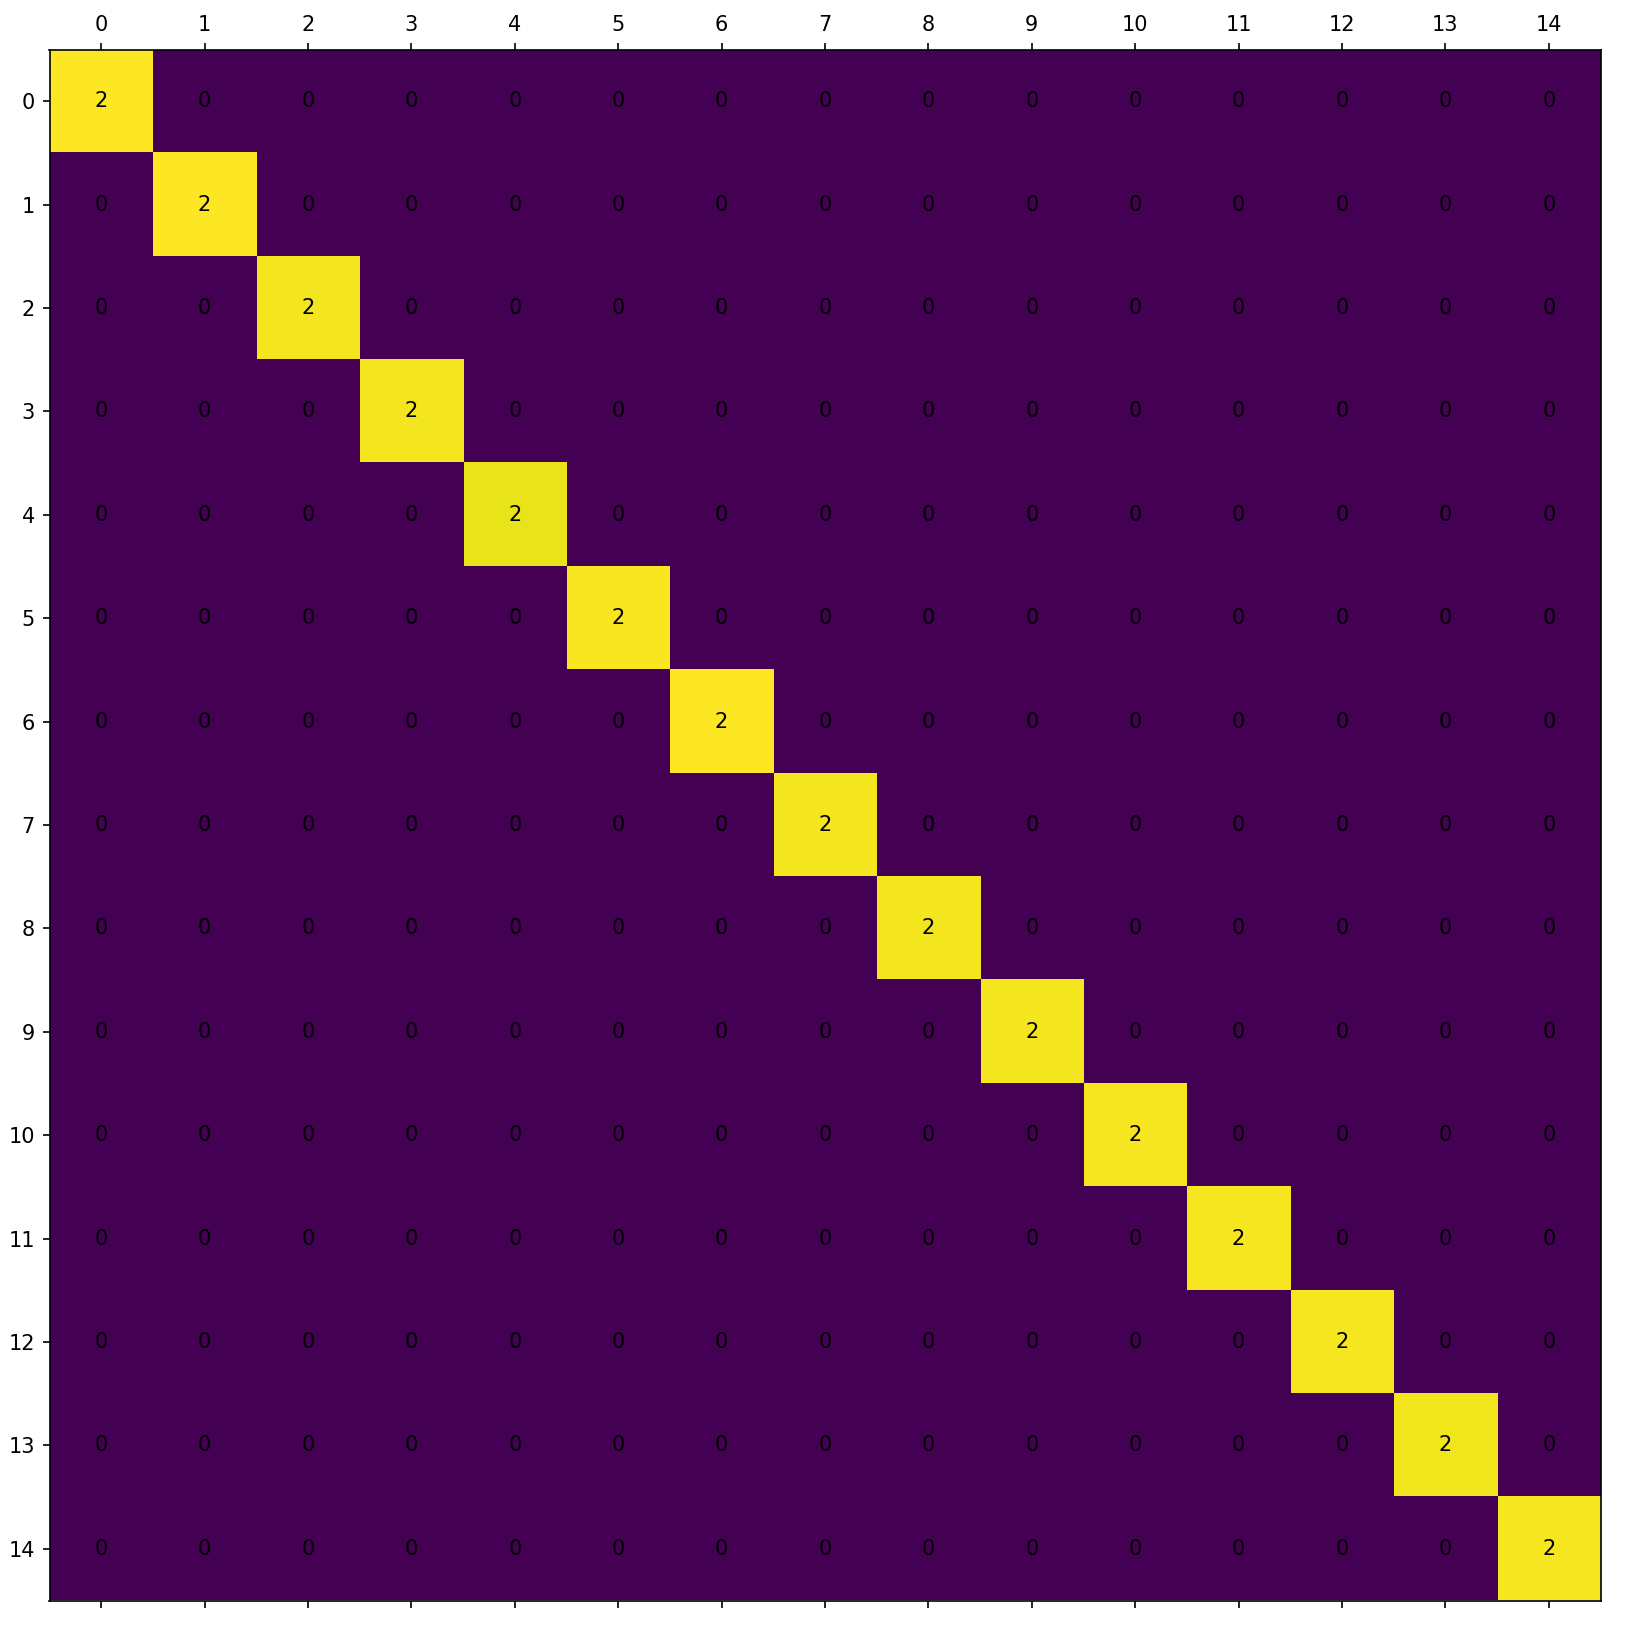

In [66]:
util.plot_mat(dZs.mean([1,2]), val_fmt=2);

<IPython.core.display.Javascript object>


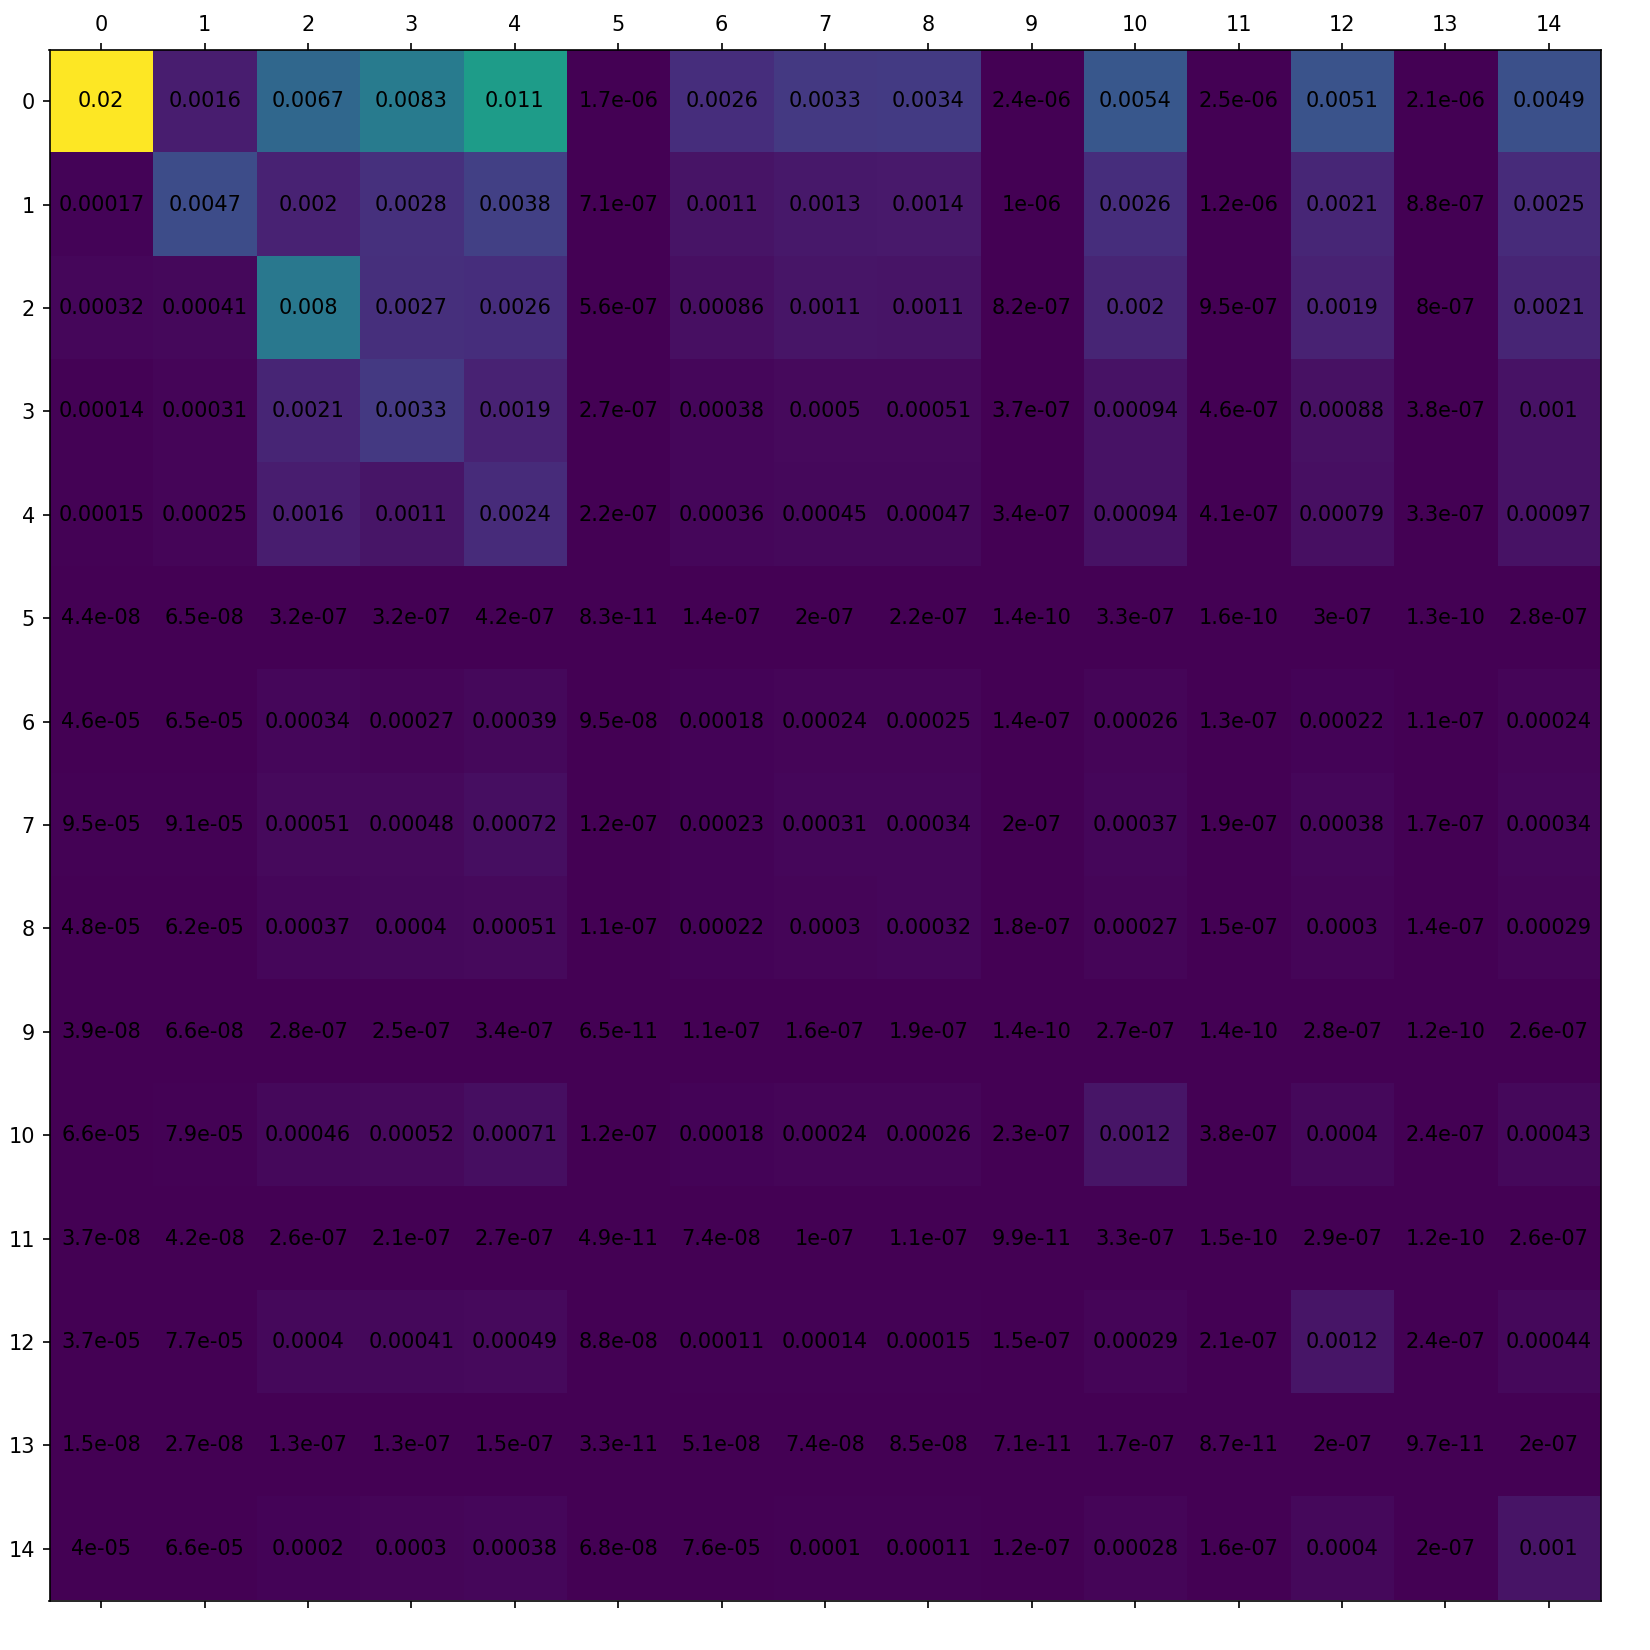

In [67]:
util.plot_mat(dZ2s.mean([1,2]), val_fmt=2);

In [489]:
d, p = encode(X, distr=True, prior=True)
d[0]

In [490]:
d[5].sigma.min()

tensor(0.2330, device='cuda:0')

In [491]:
d[4].sigma.min()

tensor(0.0748, device='cuda:0')

In [492]:
p[0].sigma.sub(d[0].sigma).mean(0).gt(.5).sum()

tensor(3, device='cuda:0')

In [493]:
idims = []
vi = 5
for vi in tqdm(range(len(p))):
#     informative = d[vi].sigma.sub(p[vi].sigma).div(p[vi].sigma).max(0)[0].lt(-.1)
    informative = d[vi].sigma.sub(p[vi].sigma).div(p[vi].sigma).mean(0).lt(-.1)
    dims = []
    # informative = (sigma < 0.8)
    for ind in np.ndindex(informative.shape):
        if informative[ind]:
            dims.append(ind)
    idims.append(dims)
len(idims), sum(map(len,idims))

/tmp/ipykernel_20966/2744519597.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for vi in tqdm(range(len(p))):


  0%|          | 0/15 [00:00<?, ?it/s]

(15, 73)

In [494]:
tbl = []
ths = torch.linspace(0.4, 0.99, 16)
dim_specs = []
for th in ths.tolist():
    informatives = [d[vi].sigma.div(p[vi].sigma).min(0)[0].lt(th) for vi in range(len(p))]
    informative = torch.stack([inf.sum() for inf in informatives])
#     informative = torch.stack([d[vi].sigma.div(p[vi].sigma).mean(0).lt(th).sum() for vi in range(len(p))])
    dim_spec = []
    for inf in informatives:
        dims = []
        for i, ind in enumerate(np.ndindex(inf.shape)):
            if inf[ind]:
                dims.append(i)
        dim_spec.append(dims)
    tbl.append(informative)
    dim_specs.append(dim_spec)

# dim_specs = [[tuple([slice(None),*list(zip(*ds))]) if len(ds) else None for ds in dim_spec] for dim_spec in dim_specs]
dim_specs = [[torch.as_tensor(ds).long().cuda().tolist() for ds in dim_spec] for dim_spec in dim_specs]
tbl = torch.stack(tbl)
tbl.shape

torch.Size([16, 15])

In [497]:
dim_specs[0]#[0]

[[57, 61, 63],
 [149],
 [261, 262, 265, 266],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [73]:
def dim_sel(t, ds):
    B = t.size(0)
    return t.view(B, -1).index_select(1,ds)
def dim_set(t, v, ds):
    B = t.size(0)
    v = torch.as_tensor(v).expand(*v.shape).to(t)
    t.view(B,-1).index_copy_(1,ds,v)

In [109]:
# dim_specs[3]

In [98]:
ths

tensor([0.4000, 0.4393, 0.4787, 0.5180, 0.5573, 0.5967, 0.6360, 0.6753, 0.7147, 0.7540, 0.7933, 0.8327, 0.8720, 0.9113, 0.9507, 0.9900])

In [95]:
tbl.sum(-1)

tensor([  8,   8,  10,  12,  17,  24,  31,  49,  70,  98, 122, 152, 184, 232, 284, 373], device='cuda:0')

In [24]:
tbl

tensor([[ 3,  1,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  1,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  1,  5,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  1,  5,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 3,  1,  5,  1,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
        [ 3,  1,  5,  4,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5],
        [ 3,  1,  5,  4,  7,  0,  0,  0,  0,  0,  2,  0,  4,  0,  5],
        [ 3,  2,  5,  4,  8,  0,  0,  0,  0,  0,  7,  0, 10,  0, 10],
        [ 3,  2,  5,  6,  8,  0,  0,  0,  0,  0, 13,  0, 16,  0, 17],
        [ 4,  2,  5,  8,  8,  0,  0,  0,  2,  0, 20,  0, 26,  0, 23],
        [ 5,  3,  5,  8,  9,  0,  0,  0,  6,  0, 27,  0, 29,  0, 30],
        [ 5,  3,  5, 10,  9,  0,  0,  7, 18,  0, 30,  0, 31,  0, 34],
        [ 5,  3,  5, 10,  9,  0,  1, 21, 25,  0, 36,  0, 34,  0, 35],
        [ 7,  3,  6, 11,  9,  0, 19, 29, 32,  0, 38,  0, 39,  0, 39],
        [10,  6, 10,

In [96]:
th_pick = 5
dim_spec = dim_specs[th_pick]
num_dim = tbl[th_pick].sum(-1).item()
ths[th_pick].item(), num_dim

(0.596666693687439, 24)

In [113]:
tbl[th_pick]#[0]

tensor([3, 1, 5, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5], device='cuda:0')

In [159]:
def E(imgs, dims=None):
    if dims is None:
        dims = dim_spec
    zs = enc(imgs)
    return torch.cat([dim_sel(z, ds) for z, ds in zip(zs, dims)], -1).cpu()

def D(vals, dims=None):
    if dims is None:
        dims = dim_spec
    zs = [z.expand(len(vals),*z.shape[1:]).contiguous() for z in _global_eps_table]
    i = 0
    vals = vals.cuda()
    for z, dim in zip(zs, dims):
        dim_set(z, vals.narrow(1,i,len(dim)), dim)
        i += len(dim)
    return dec(zs)

def R(z):
    return E(D(z))

In [124]:
z = E(X)
z.shape

torch.Size([24, 24])

In [126]:
r = D(z)
r.shape

torch.Size([24, 1, 32, 32])

In [112]:
# util.plot_imgs(X);
# util.plot_imgs(r);
# # util.plot_imgs(decs(encs(X)));

In [127]:
fullQ = []
total = 10000 if dname in {'mnist', 'cifar10'} else 256
bs = 1000 if dname in {'mnist', 'cifar10'} else 8
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    x = next(loader)[0]
    fullQ.append(E(x))
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
dout = fullQ.size(-1)
fullQ.shape

/tmp/ipykernel_20966/243736467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=total)


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 24])

In [154]:
bsnum = 24
din = num_dim
prior = lambda B: torch.randn(B, num_dim)

In [136]:
lat = prior(bsnum)
lat.shape

torch.Size([24, 24])

In [147]:
# util.plot_imgs(D(lat));
# util.plot_imgs(D(E(D(lat))));

In [139]:
def interpolate(x,y,n=10):
    delta = torch.linspace(0,1,n).view(1,n,1).to(x.device)
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    return delta*y + (1-delta)*x

In [140]:
sel = np.arange(len(lat))[:4]
nsteps = 10
trav = interpolate(lat[sel], lat[(sel+1)%len(lat)], nsteps)
trav.shape

torch.Size([4, 10, 24])

In [148]:
# util.plot_imgs(D(util.combine_dims(trav,0,2).contiguous()), W=nsteps);

In [142]:
niter = 8
qs = [lat]
rs = []

In [143]:
for _ in tqdm(range(niter)):
    rs.append(D(qs[-1]))
    qs.append(E(rs[-1]))
rs = torch.stack(rs)
qs = torch.stack(qs)
qs.shape, rs.shape

/tmp/ipykernel_20966/2183506975.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(niter)):


  0%|          | 0/8 [00:00<?, ?it/s]

(torch.Size([9, 24, 24]), torch.Size([8, 24, 1, 32, 32]))

In [132]:
def response_mat(Q, encode, decode, n_interv=None, scales=None,
                 force_different=False,
                 max_batch_size=None, device=None, pbar=None):
    if scales is not None:
        raise NotImplementedError

    @torch.no_grad()
    def response_function(q):
        if device is not None:
            q = q.to(device)
        r = encode(decode(q))
        if isinstance(r, distrib.Normal):
            r = r.loc
        return r

    B, D = Q.shape

    if n_interv is None:
        n_interv = B
    if max_batch_size is None:
        max_batch_size = n_interv

    itr = enumerate(Q.t())
    if pbar is not None:
        itr = pbar(itr, total=D)
        
    resps = []
    for i, qi in itr:  # Opy(D) (n_interv is parallelized)
        order = torch.randperm(B)
        iorder = order.clone()
        if force_different:
            iorder[1:] = order[:-1]
            iorder[0] = order[-1]
        qsel = slice(0,n_interv) if force_different else torch.randint(B, size=(n_interv,))
        isel = slice(0,n_interv) if force_different else torch.randint(B, size=(n_interv,))
        q = Q[order[qsel]]
        dq = q.clone()
        dq[:, i] = qi[iorder[isel]]
        z = util.process_in_batches(response_function, q, batch_size=max_batch_size)
        dz = util.process_in_batches(response_function, dq, batch_size=max_batch_size)
        resps.append(dz.sub(z).pow(2).mean(0).sqrt())
    return torch.stack(resps) / np.sqrt(2)

In [133]:
rmat = response_mat(fullQ, E, D, n_interv=50, max_batch_size=bs, pbar=tqdm)
rmat.shape

/tmp/ipykernel_20966/4090980778.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  itr = pbar(itr, total=D)


  0%|          | 0/24 [00:00<?, ?it/s]

torch.Size([24, 24])

<IPython.core.display.Javascript object>


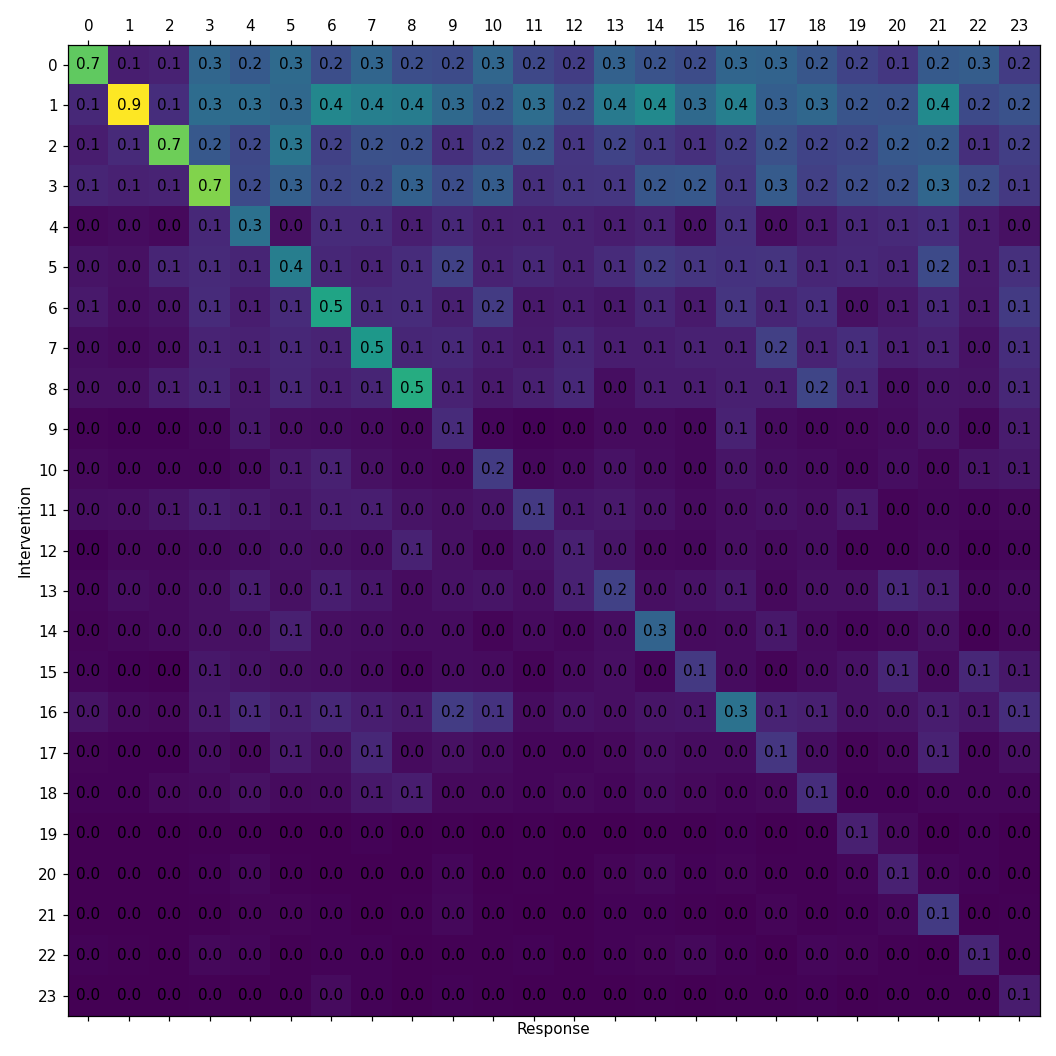

In [134]:
# threshold = 0.5
# threshold_2d = 0.1

sel = torch.arange(len(rmat))
# sel = torch.arange(len(rmat))[rmat.diag() > threshold]
# bsel = torch.arange(len(rmat))[rmat.diag() <= threshold]
# sel, bsel
# rsel = rmat.clone()
rsel = rmat[sel][:,sel]
hside = 0.4
util.plot_mat(rsel, val_fmt='.1f',
              figsize=(len(rsel)*hside, hside*len(rsel))
             ) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout();
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

In [149]:
# util.plot_imgs(rs[:,np.random.randint(rs.shape[1])], W=niter);

In [42]:
# util.plot_imgs(rs[0]);

In [43]:
# util.plot_imgs(rs[-1]);

In [145]:
Q = lat.clone()
Q.shape

torch.Size([24, 24])

In [150]:
dims = 0,1
# dims = 1,2
# dims = 0,2
# dims = 43, 44
# dims = 35, 37
# dims = 45, 53
# dims = 36, 52
# dims = 29, 53
# dims = 137, 135
dims = 1, 16

ix, iy = dims
dims

(1, 16)

In [169]:
# stretch = .1

# dims3d = (0,1,2)
# # dims3d = (*dims, 29)

# pts = torch.randn(*fullQ.shape)
# # pts = fullQ.clone()
# pts_steps = [pts]


# original_pts = pts.clone()

# mn, mx = pts.min(0)[0], pts.max(0)[0]
# rg = mx-mn
# mn, mx = mn-stretch*rg, mx+stretch*rg

# def _plt_pts(pts, cs='C0', fsize=6, **kwargs):
#     fg = plt.figure(figsize=(fsize,fsize))
#     ax = fg.add_subplot(111, projection='3d');

#     ax.scatter(*pts[:,dims3d].t().numpy(), marker='.', alpha=0.3, c=cs, **kwargs)
#     ax.set_xlabel(f'Dimension {dims3d[0]}')
#     ax.set_ylabel(f'Dimension {dims3d[1]}')
#     ax.set_zlabel(f'Dimension {dims3d[2]}');

# # plt.figure(figsize=(8,8))
# # plt.title('Posterior')
# # plt.xlabel(f'Dimension {ix}')
# # plt.ylabel(f'Dimension {iy}')
# # # plt.xlim(mn[0], mx[0])
# # # plt.ylim(mn[1], mx[1])
# # hist, *other = np.histogram2d(*pts.t().cpu().numpy(), bins=nside, normed=True, range=torch.stack([mn[list(dims)], mx[list(dims)]]).t().cpu().numpy())
# # plt.imshow(hist.T[::-1], cmap='Blues', interpolation='spline36',
# #            extent=[mn[0].item(), mx[0].item(),mn[1].item(), mx[1].item()], aspect=aspect_ratio);

# # _plt_pts(pts)

In [60]:
for i in range(8):
    newpts = []
    for v, in tqdm(DataLoader(TensorDataset(pts), batch_size=bs), desc=f'Cycling {len(pts)} samples'):
        with torch.no_grad():
            newpts.append(R(v))
    pts = torch.cat(newpts)
    pts_steps.append(pts)
# del newpts
PTS = torch.stack(pts_steps)
PTS.shape

/tmp/ipykernel_7185/311462356.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(pts), batch_size=bs), desc=f'Cycling {len(pts)} samples'):


Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling 10000 samples:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([9, 10000, 3])

In [95]:
# _plt_pts(pts,fsize=12);
# plt.title(f'Step {len(pts_steps)-1}');

In [62]:
k = 8
pts = PTS[k]

In [63]:
from sklearn import cluster
# cmdl = cluster.AgglomerativeClustering(
#     n_clusters=None, 
#     distance_threshold=0.1, 
#     linkage='single')
# cmdl = cluster.Birch(threshold=0.8, branching_factor=20, n_clusters=None)
# cmdl = cluster.KMeans(n_clusters=20, random_state=0)
# cmdl = cluster.DBSCAN(eps=0.1, min_samples=10)
cmdl = cluster.DBSCAN(eps=0.12, min_samples=4)
# cmdl = cluster.OPTICS(
# #     min_samples=10, 
#     min_samples=50, 
# #     min_cluster_size=0.02, 
# #     metric='l2', 
# #     cluster_method='dbscan', 
#     max_eps=5,
# #     xi=0.01,
# )
clts = torch.from_numpy(cmdl.fit(pts.numpy()).labels_)
clts.max()+1, (clts>0).sum()/len(clts)*100

(tensor(52), tensor(86.3800))

In [152]:

# _plt_pts(pts, cs=[distinct_colors[(c%(len(distinct_colors)-1))+1] if c > 0 else 'w' for c in clts], fsize=12);
# # _plt_pts(pts[torch.from_numpy(clts)>0], cs=[distinct_colors[c+1] if c > 0 else 'w' for c in clts if c > 0], fsize=12);
# plt.title(f'Step {k}');
# # plt.savefig(str(imgroot/f'clusters-step{k}.png'));

In [97]:
_plt_pts(pts,fsize=12);
plt.title(f'Step {len(pts_steps)-1}');
plt.title(f'Step {k}');
# plt.savefig(str(imgroot/f'pts-step{k}.png'));

In [136]:
# _plt_pts(original_pts, cs=[distinct_colors[(c%(len(distinct_colors)-1))+1] if c > 0 else 'w' for c in clts], fsize=12);

In [86]:
cnts = torch.bincount(clts[clts>0])
order = cnts.sort(0,descending=True)[1]

In [87]:
nums = cnts[order].float()
nums[1:-1].div(nums[:-2]).min(0)
cnts[order][:50]

tensor([1645, 1009,  869,  770,  708,  537,  487,  357,  339,  335,  293,  269,  226,  143,  130,   69,   61,   61,   51,   28,   27,   24,   16,   15,   14,   10,   10,    9,    9,    9,    8,    7,    7,    7,    7,    7,    6,    5,    5,    5,    5,    5,    4,    4,    4,    4,    4,    4,
           4,    3])

In [102]:
# qsel = original_pts[clts == order[1]]
# util.plot_imgs(D(qsel[torch.randperm(qsel.size(0))[:20]]));

In [98]:
# topk = 20
# egs = 8
# imgs = []
# for o in order[:topk]:
#     qsel = pts[clts == o]
# #     qsel = original_pts[clts == o]
#     imgs.append(D(qsel[torch.randperm(qsel.size(0))[:egs]]))
# print(cnts[order[:topk]]/len(pts)*100)
# fg, axs = util.plot_imgs(torch.cat(imgs), H=topk, W=egs);
# len(axs)

In [137]:
# plt.savefig(str(imgroot/f'cluster-samples.png'));

In [132]:
axs = np.array(axs).reshape(topk,egs)
axs.shape

(20, 8)

In [133]:
for axrow, p in zip(axs, (cnts[order[:topk]]/len(pts)*100).tolist()):
    for a in axrow:
        plt.sca(a)
        plt.axis('on')
        plt.xticks([],[])
        plt.yticks([],[])
    plt.sca(axrow[0])
    plt.ylabel(f'{p:2.1f}%')

In [134]:
plt.subplots_adjust(left=0.05);
# plt.subplots_adjust(wspace=between, hspace=between, left=border, right=1 - border, bottom=border, top=1 - border)

In [135]:
(cnts[order[:topk]]/len(pts)*100).sum()

tensor(85.6400)

In [65]:
PTS.shape

torch.Size([9, 10000, 3])

In [66]:
motion = PTS[1:] - PTS[:-1]

In [74]:
motion.shape

torch.Size([8, 10000, 3])

In [73]:
# 10000000 ** (1/64)

In [75]:
motion.norm(2, -1).mean(-1)

tensor([0.1835, 0.1272, 0.1008, 0.0848, 0.0740, 0.0659, 0.0599, 0.0544])

In [78]:
motion.mean(1).norm(2,-1)

tensor([0.0742, 0.0602, 0.0488, 0.0407, 0.0342, 0.0293, 0.0258, 0.0231])

In [115]:
# from sklearn import manifold
# import umap

In [204]:
# # embedding = manifold.Isomap(n_neighbors=10, n_components=2)
# # embedding = manifold.TSNE(n_components=2)
# embedding = umap.UMAP(n_neighbors=20)
# psel = pts[clts == order[1]]
# psel = pts
# pts_t = torch.as_tensor(embedding.fit_transform(psel.numpy()))

In [202]:
# cl = psel[:,1]
# cl = (cl-cl.min()) / (cl.max()-cl.min())
# cl.min(), cl.max()
# _plt_pts(psel,cl.numpy().tolist(), cmap='viridis',fsize=6);

In [203]:
# plt.figure()
# plt.scatter(*pts_t.t().numpy(), c=cl.numpy().tolist(), cmap='viridis');

In [195]:
# xpts = torch.randn(50, 2)*3 + torch.as_tensor([2.,6])
# xpts = torch.linspace(0,1,50).float().view(-1, 1)
# xs, xe = torch.as_tensor([11.5, 5.4]), torch.as_tensor([-5.3, 7])
# xpts = (1-xpts)*xs.view(1,-1) + xpts*xe.view(1,-1)

In [196]:
plt.figure(24)
# plt.scatter(*xpts.t().numpy(), marker='x');

plt.plot(*xpts.t().numpy());

In [197]:
vpts = torch.as_tensor(embedding.inverse_transform(xpts.numpy()))
vpts.shape

torch.Size([50, 3])

In [198]:
plt.figure(23)
# plt.gca().scatter(*vpts.t().numpy(), marker='x');
plt.gca().plot(*vpts.t().numpy());

<Axes3DSubplot:xlabel='Dimension 0', ylabel='Dimension 1'>

In [138]:
# Qsel = Q[:,dims]
# pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# # plt.figure()
# # plt.scatter(*pts.t(), marker='.', c='k');
# U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
# S = S.sqrt()
# print('S',S)
# print(U)
# Q.shape, Qsel.shape

In [160]:
rg = 5

# mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
# mn, mx = mn.view(-1), mx.view(-1)

# print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(din)*-rg, torch.ones(din)*rg

In [161]:
bidx = 9
bidx = 0
# qbase = Q[bidx]

other_dims = [i for i in range(din) if i not in dims]

qbase = torch.randn(din)

z0 = 0.
# qbase[other_dims] = z0

qbase

tensor([-0.9969, -1.7420,  0.0194,  0.4991, -0.4990, -0.8420,  0.7885,  0.6921,  1.0283, -0.0425, -0.7173, -1.1755,  1.1840,  2.0797, -0.2822,  1.3156, -0.9081,  0.8545, -0.5919, -0.2363,  0.2274, -1.0570, -1.1557, -0.1880])

In [162]:
n = 32
nside = n
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = qbase.unsqueeze(0).expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([1024, 24])

In [163]:
starts = vecs[...,dims]
ends = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Cycling {len(vecs)} samples'):
    with torch.no_grad():
        ends.append(R(v)[...,dims])
starts = starts.view(h,w,2)
ends = torch.cat(ends).view(h,w,2)
dels = ends.sub(starts)
delmap = dels.permute(1,0,2).numpy()[::-1]
ends.shape

/tmp/ipykernel_20966/2200089322.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Cycling {len(vecs)} samples'):


Cycling 1024 samples:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 32, 2])

In [164]:
# # dmap = torch.cdist(starts, Qsel).min(-1)[0].view(n,n)
# dmap = torch.cdist(starts, cts).min(-1)[0].view(n,n)
# # dmap = torch.cdist(starts, Qsel).mean(-1).view(n,n)
# distmap = dmap.numpy()
# dmap = dmap.t().numpy()[::-1]

mags = dels.pow(2).sum(-1)
costmap = mags.numpy()
mags = mags.t().numpy()[::-1]
# mags = deltas.view(h,w,2)[...,0]

normdels = dels.div(dels.norm(dim=-1,keepdim=True))
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)
divM = get_divergence(dels)
ndivM = get_divergence(normdels)

happymap = divM<0
happy = happymap.t().numpy()[::-1]
# landscape = divM - divM.min()
# divM -= divM.min()
divergence = divM
divM = divM.t().numpy()[::-1]
posterior_logits = ndivM.mul(-1)
ndivM = posterior_logits.t().numpy()[::-1]

divMprop = torch.from_numpy(divM.copy()).clone()
divMprop[divMprop>0] /= divMprop[divMprop>0].max().abs()
divMprop[divMprop<0] /= divMprop[divMprop<0].min().abs()
divMprop = divMprop.numpy()

ndivMprop = torch.from_numpy(ndivM.copy()).clone()
ndivMprop[divMprop>0] /= ndivMprop[divMprop>0].max().abs()
ndivMprop[divMprop<0] /= ndivMprop[divMprop<0].min().abs()
ndivMprop = ndivMprop.numpy()


# fmag = mags + dmap
# spacemap = distmap + costmap

fmag = mags
spacemap = costmap

In [165]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(1.0000), tensor(0.0636), tensor(0.0636))

In [166]:
n = 10
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = qbase.unsqueeze(0).expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy

emb = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Decoding {len(vecs)} samples'):
    with torch.no_grad():
        emb.append(D(v))
emb = torch.cat(emb)
C, H, W = emb.shape[-3:]
emb = util.split_dim(emb, h,w)
emb = torch.from_numpy(emb.numpy()[:,::-1].copy()).contiguous()
emb = emb.permute(2,1,3,0,4).reshape(C, h*H, w*W)
# imshape = imgs.shape[-3:]
# imgs = torch.from_numpy(util.split_dim(imgs, h,w).numpy()[:,::-1].copy()).contiguous().permute(1,0,2,3,4).contiguous()
# imgs = util.combine_dims(imgs, 0,2)
emb.shape

/tmp/ipykernel_20966/2633775350.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=bs), desc=f'Decoding {len(vecs)} samples'):


Decoding 100 samples:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 320, 320])

In [167]:
threshold = 0.1

pts = fullQ.clone()#[:,dims]

ext = pts[:,other_dims]
valid = (threshold >= ext).mul(-threshold<=ext).prod(-1)
valid[:] = 1
pts = pts[valid.bool()]
pts = pts[:,dims]
len(pts) / len(valid)

1.0

<IPython.core.display.Javascript object>


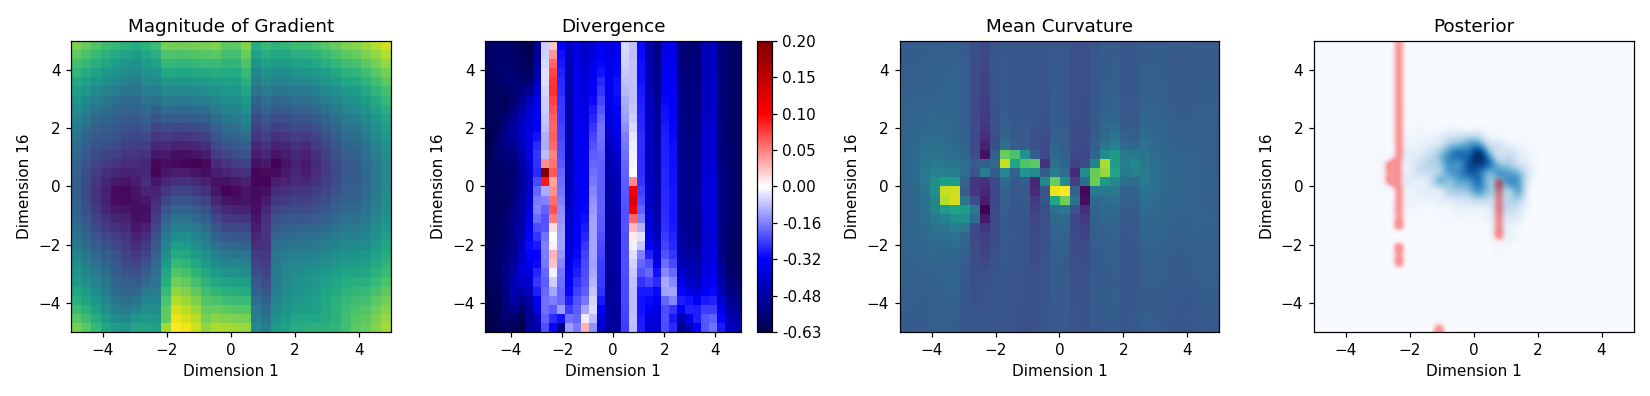

<IPython.core.display.Javascript object>


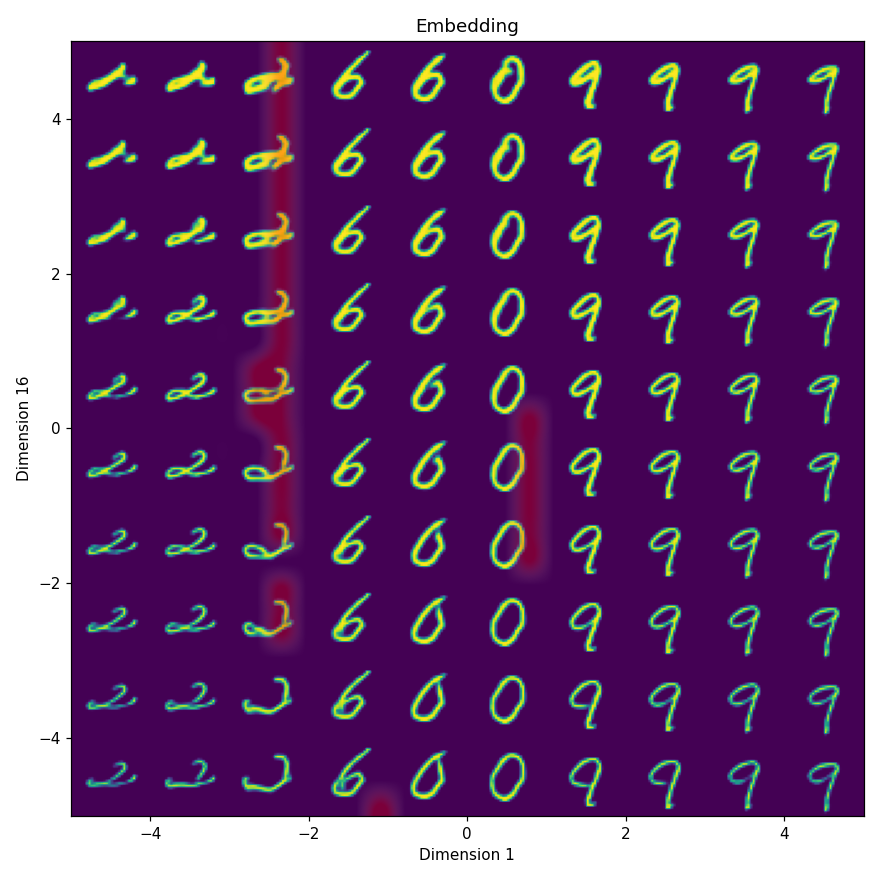

In [168]:
im = fmag
im = divM
# im = happy

# plt.figure()
# # plt.title('Map')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(im, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
# plt.tight_layout()

aspect_ratio = 'auto'
# aspect_ratio = 1

fg, axs = plt.subplots(1,4, figsize=(15,3.6))

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(mags**0.5, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[1])
# plt.title('Distance Mags')
# plt.imshow(dmap, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(ndivMprop, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[3])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*pts.t().cpu().numpy(), bins=nside, normed=True, range=torch.stack([mn[list(dims)], mx[list(dims)]]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Blues',interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
badsel = np.ones((*happy.shape,4))
badsel[...,-1] = 0.
badsel[~happy] = [1,0,0,1]
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8,
           alpha=0.4,interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags);
plt.tight_layout();

plt.figure(figsize=(8,8))
plt.imshow(emb.permute(1,2,0),  extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8,
           alpha=0.3,interpolation='spline36',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)

plt.title('Embedding')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.tight_layout();

In [85]:
# plt.figure(13)

In [168]:
# plt.savefig(str(imgroot/f'{dname}-{dims[0]}-{dims[1]}.png'));

In [204]:
from sklearn import mixture

In [447]:
N_base = 4

In [448]:
lbl_idx = 1

imgs = dataset.get_data().images

lbl_sel = dataset.get_data().targets == lbl_idx
lbl_sel = torch.arange(len(lbl_sel))[lbl_sel]
len(lbl_sel)

6742

In [449]:
Xa = imgs[lbl_sel[:N_base]].float().div(255).cpu()
Xa.shape

torch.Size([4, 1, 32, 32])

In [450]:
za = E(Xa)
za.shape

torch.Size([4, 24])

<IPython.core.display.Javascript object>


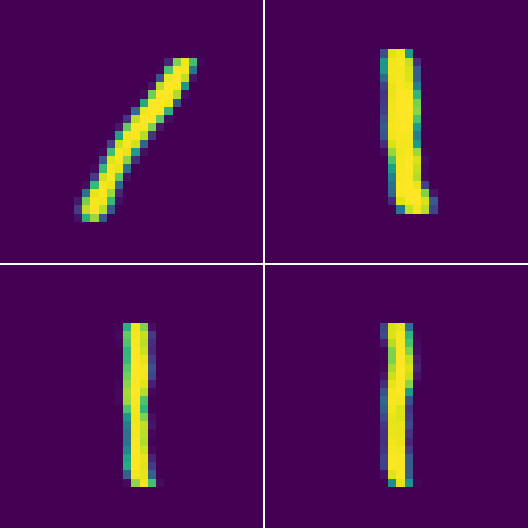

In [451]:
util.plot_imgs(D(za));

In [346]:
# z = za + torch.randn_like(za) * 0.4
# # z /= z.std(0,keepdim=True)
# util.plot_imgs(D(z));

<IPython.core.display.Javascript object>


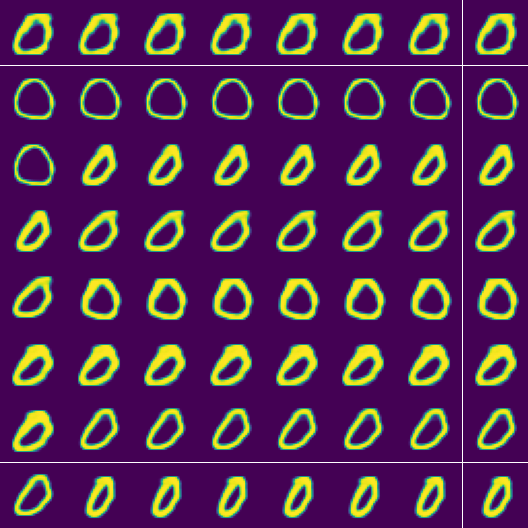

In [347]:
mm = mixture.GaussianMixture(n_components=8, covariance_type='full', random_state=0)
mm.fit(za.numpy())

zmm, _ = mm.sample(64)
zmm = torch.as_tensor(zmm)
util.plot_imgs(D(zmm));

In [357]:
level = 5

zrs_ = [za]

In [358]:
for _ in tqdm(range(level)):
    zrs_.append(R(zrs_[-1]))
zrs = torch.stack(zrs_)
zrs.shape

/tmp/ipykernel_20966/1186046196.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(level)):


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([6, 8, 24])

In [366]:
torch.empty?

In [369]:
z.shape

torch.Size([24, 24])

In [370]:
buffer = torch.empty(100,z.size(1), device=z.device, dtype=z.dtype)
buffer.shape

torch.Size([100, 24])

In [371]:
buffer[0]

tensor([     0.0000,      0.0000,  14108.8906,      0.0000,      0.0000,      0.0000,     -0.0022,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000])

In [372]:
buffer.narrow(0, 0, len(z)).copy_(z);

In [373]:
buffer[0]

tensor([-1.2625,  0.2712,  0.2251,  0.0945,  0.1552, -0.1386, -0.5554, -0.2771,  0.6029,  0.6595, -1.8263,  1.0376,  0.6907,  2.1655,  2.2175,  0.6699, -0.7182,  0.8437,  0.6153,  0.8788, -0.0569,  1.2573,  0.0646, -2.1285])

In [375]:
from collections import deque

In [376]:
d = deque(range(10))
d

deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [379]:
d.pop()

9

In [382]:
buffer[0].gt(0).logical_not()

tensor([ True, False, False, False, False,  True,  True,  True, False, False,  True, False, False, False, False, False,  True, False, False, False,  True, False, False,  True])

In [359]:
cands = prior(100)
cands = cands * 0.4 + za[torch.randint(len(za), size=(len(cands),))]
resps_ = [cands]
cands.shape

torch.Size([100, 24])

In [360]:
for _ in tqdm(range(level)):
    resps_.append(R(resps_[-1]))
resps = torch.stack(resps_)
resps.shape

/tmp/ipykernel_20966/3992853716.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(level)):


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([6, 100, 24])

In [361]:
agr = torch.cdist(resps, zrs)
agr.shape

torch.Size([6, 100, 8])

In [362]:
top_num = 4
top_wts = torch.ones(top_num)
top_wts = F.normalize(top_wts, p=1, dim=0)
score = agr.topk(4,dim=-1,largest=False)[0] @ top_wts
score.shape

torch.Size([6, 100])

<IPython.core.display.Javascript object>


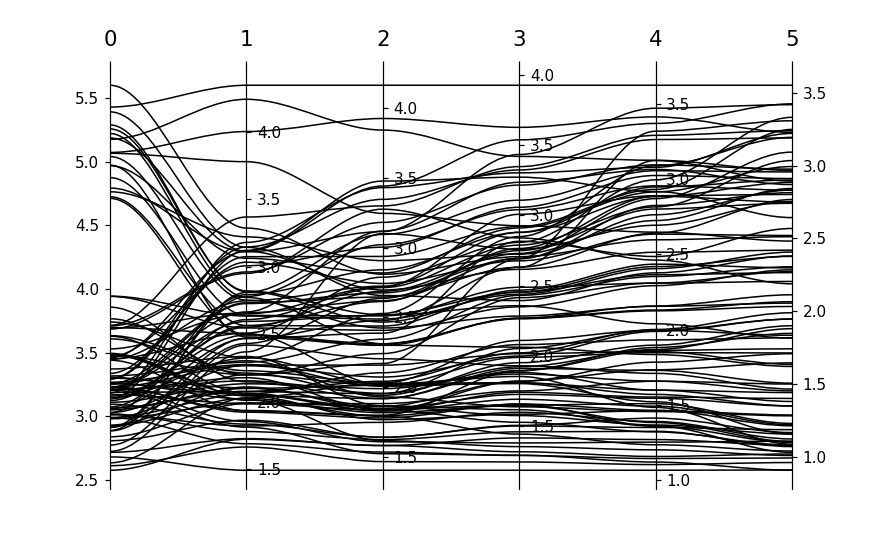

In [363]:
util.plot_parallel_coords(score.t().numpy(), );

In [ ]:
crit = score[1:].sub(score[:-1])

In [364]:
gold = crit.lt(0).prod(0).bool()
# gold = score[1:].sub(score[:-1]).mean(0).lt(0).bool()
gold.float().mean()

tensor(0.5800)

<IPython.core.display.Javascript object>


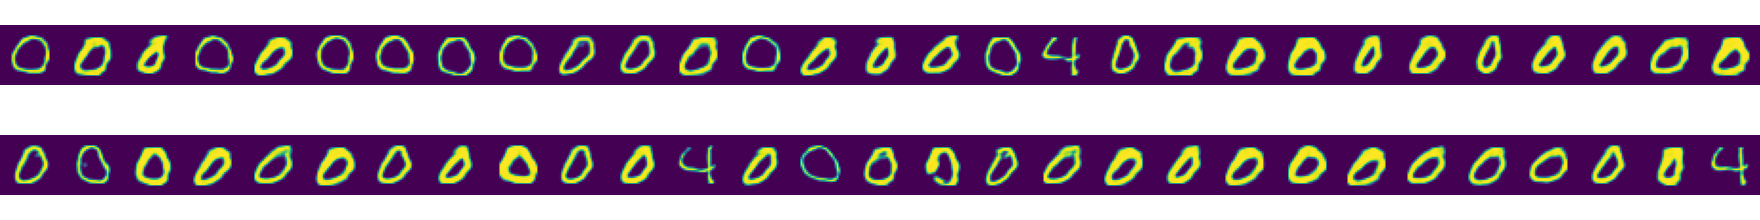

In [365]:
util.plot_imgs(D(cands[gold]));

In [ ]:
gold = score[1:].sub(score[:-1]).mean(0).lt(0).prod(0).bool()

In [383]:
from controller import GMM, LatentResponse

In [386]:
za.shape

torch.Size([8, 24])

In [459]:
gmm = GMM(encode=E, decode=D, n_components=2, covariance_type='full', )
gmm

GMM()

In [460]:
gmm.fit_latent(za)

<IPython.core.display.Javascript object>


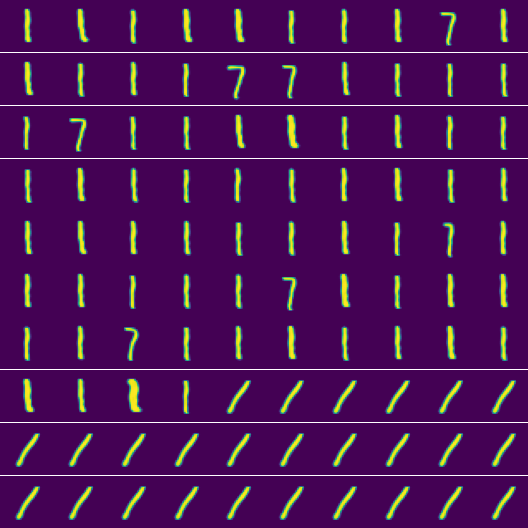

In [461]:
util.plot_imgs(gmm.sample(100));

<IPython.core.display.Javascript object>


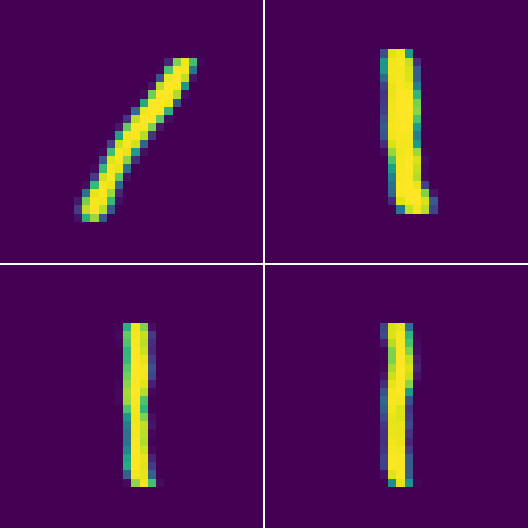

In [462]:
util.plot_imgs(D(za));

In [478]:
lr = LatentResponse(encode=E, decode=D, temp=0.2, levels=5, n_neighbors=4, only_core=False, max_size=512, )

In [479]:
lr.fit_latent(za)

<IPython.core.display.Javascript object>


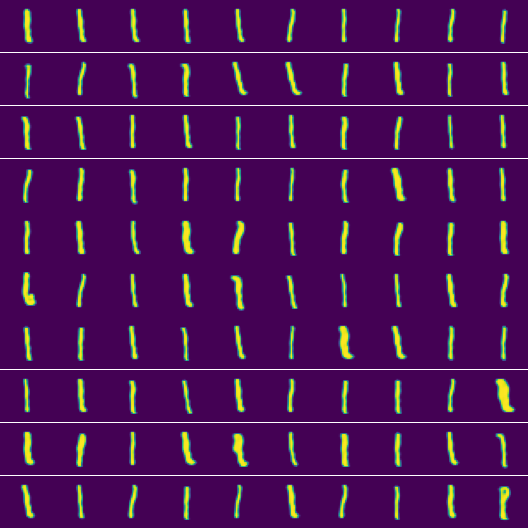

In [486]:
lz = lr.sample_latent(100)
util.plot_imgs(D(lz));

In [401]:
lr.nodes.ptr, lr.nodes.buffer.shape

(171, torch.Size([256, 24]))

In [393]:
lr.nodes.max_size

256